In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set2')

In [3]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [4]:
latest_niv = get_latest_file_glob('datagov_archive/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0 2020-11-05      0      0            0                    0          0   
1 2020-11-05      0      0            0                    0          0   
2 2020-11-05      0      0            0                    0          0   
3 2020-11-05      0      0            0                    0          0   
4 2020-11-05      0      0            0                    0          0   

  corona_result age_60_and_above gender         test_indication  
0         שלילי               No    זכר  Contact with confirmed  
1         שלילי              Yes    זכר                   Other  
2         שלילי               No   נקבה                   Other  
3         שלילי               No   נקבה                   Other  
4         שלילי               No   נקבה                   Other

In [5]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [6]:
latest_bdi = get_latest_file_glob('datagov_archive/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [7]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [8]:
bdi.head()

test_date result_date corona_result  lab_id  test_for_corona_diagnosis  \
0 2020-08-09  2020-08-09         שלילי       2                          1   
1 2020-08-09  2020-08-09         חיובי       2                          1   
2 2020-08-10  2020-08-10         שלילי       2                          1   
3 2020-03-11  2020-03-11         שלילי       3                          1   
4 2020-03-11  2020-03-11         שלילי       3                          1   

  is_first_Test orig_test_date  
0           Yes            NaT  
1            No            NaT  
2           Yes            NaT  
3           Yes     2020-03-11  
4           Yes     2020-03-11

In [9]:
bdi.shape

(5028244, 7)

In [10]:
niv.corona_result.value_counts()

שלילי    2398360
חיובי     218535
אחר        40496
Name: corona_result, dtype: int64

In [11]:
bdi.corona_result.value_counts()

שלילי                 4534651
חיובי                  386569
חיובי גבולי             55073
לא בוצע/פסול 999        48236
לא ודאי                  1644
בעבודה                    840
חיובי גבולי באיגום        502
לא ודאי ישן               397
חיובי באיגום              332
Name: corona_result, dtype: int64

In [12]:
niv.corona_result.value_counts()

שלילי    2398360
חיובי     218535
אחר        40496
Name: corona_result, dtype: int64

In [13]:
niv.test_indication.value_counts()

Other                     2466372
Contact with confirmed     166586
Abroad                      24433
Name: test_indication, dtype: int64

In [14]:
niv.age_60_and_above.value_counts()

No     1838555
Yes     271866
Name: age_60_and_above, dtype: int64

In [15]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [16]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [17]:
bdi_result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'חיובי גבולי': 'borderline',
    'לא בוצע/פסול 999': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
bdi['corona_result'] = bdi.corona_result.map(bdi_result_map)

In [18]:
bdi.corona_result.value_counts()

negative       4534651
positive        386569
borderline       55073
not_done         48236
uncertain         1644
in_progress        840
Name: corona_result, dtype: int64

In [19]:
rec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

In [20]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

total_tests_count   size  min  max       mean  median  test_sum
0                  2      6    6   17  12.833333      13        12
1                  3  11061    2  112  16.665582      17     33183
2                  4   5081    2  114  21.462114      21     20324
3                  5   3127    2  106  24.647905      25     15635
4                  6   1786    6   96  27.668533      27     10716
5                  7   1063    8  108  30.398871      30      7441
6                  8    597    3  103  33.475712      33      4776
7                  9    357    3   78  35.700280      35      3213
8                 10    573    5  106  41.130890      41      5730

In [21]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

index  total_tests_count
0    size       23651.000000
1     min           2.000000
2     max          12.000000
3    mean           4.320156
4  median           4.000000

In [22]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


days_between_pos_and_neg total_tests_count age_group gender  \
9432                        114                 4       60+    זכר   
12342                       112                 3     30-39    זכר   
9304                        111                 4     20-29    זכר   
1600                        108                 7     40-49   נקבה   
6311                        106                 5     30-39    זכר   
23175                       106               10+      0-19   נקבה   
9696                        105                 4     30-39   נקבה   
456                         103                 8     50-59   נקבה   
20936                       103                 3      0-19    זכר   
23273                       100               10+       60+    זכר   

              test_indication  
9432                    Other  
12342  Contact with confirmed  
9304                    Other  
1600   Contact with confirmed  
6311   Contact with confirmed  
23175  Contact with confirmed  
9696                    Other  
456    Contact with confirmed  
20936                  Abroad  
23273  Contact with confirmed

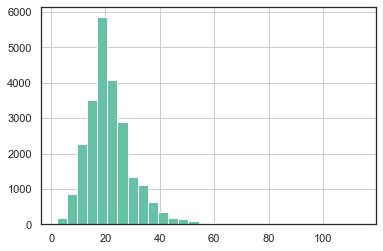

In [23]:
rec.days_between_pos_and_neg.hist(bins=30)

In [24]:
iso = pd.read_csv(get_latest_file_glob('datagov_archive/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

date  isolated_today_contact_with_confirmed  isolated_today_abroad  \
0  2020-11-04                                  27410                  32705   
1  2020-11-03                                  28036                  33022   
2  2020-11-02                                  28866                  33886   
3  2020-11-01                                  29461                  33492   
4  2020-10-31                                  29067                  31626   

  new_contact_with_confirmed new_from_abroad  
0                       2875            2265  
1                       2574            2271  
2                       2716            2486  
3                       2375            2987  
4                       1092            1455

In [25]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [26]:
niv.age_60_and_above.value_counts()

No     1838555
Yes     271866
Name: age_60_and_above, dtype: int64

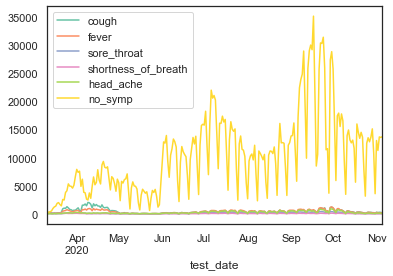

In [27]:
niv.groupby('test_date')[symptom_cols].sum().plot()

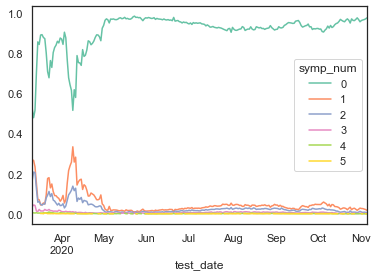

In [28]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

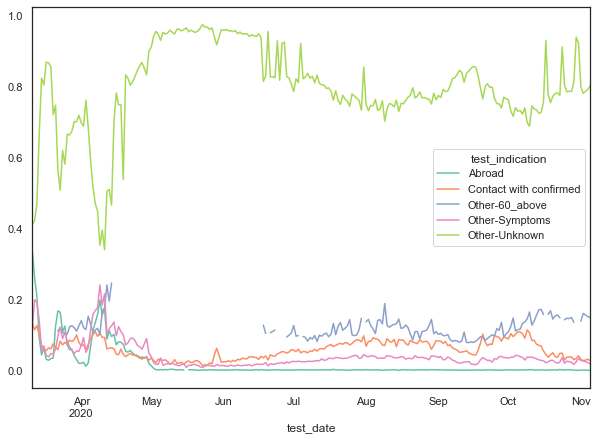

In [29]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

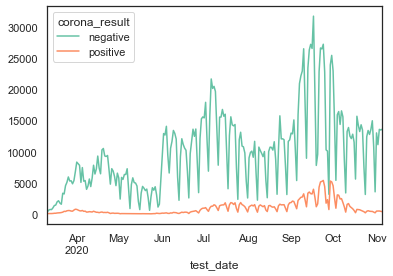

In [30]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [31]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

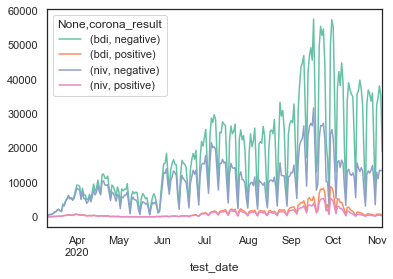

In [32]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

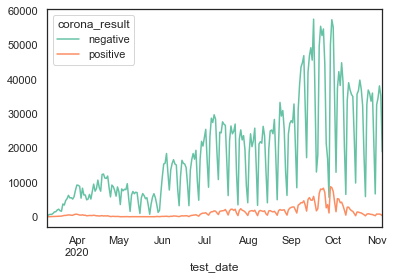

In [33]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [34]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'corona_result']].fillna('Other').groupby(['test_date', 'corona_result'], sort=False).size().unstack()
pone[pone.positive>20]

corona_result  negative  positive  Other  in_progress  not_done  borderline  \
test_date                                                                     
2020-08-09      21219.0    1613.0    NaN          1.0      77.0        94.0   
2020-08-10      21918.0    1859.0    NaN          1.0     112.0       162.0   
2020-03-12        615.0      31.0    NaN          2.0       1.0         NaN   
2020-03-25       5304.0     502.0   49.0         21.0      42.0         NaN   
2020-03-13        721.0      33.0    NaN          NaN       NaN         NaN   
...                 ...       ...    ...          ...       ...         ...   
2020-11-02      34692.0     785.0  110.0          5.0     120.0       118.0   
2020-11-03      38201.0     809.0   76.0          5.0     225.0       142.0   
2020-11-04      35193.0     679.0  209.0          6.0     138.0       137.0   
2020-11-01      32685.0     806.0  153.0          6.0      87.0        94.0   
2020-11-05      18961.0     308.0    NaN          2.0     133.0        59.0   

corona_result  uncertain  
test_date                 
2020-08-09           NaN  
2020-08-10           NaN  
2020-03-12           NaN  
2020-03-25           NaN  
2020-03-13           NaN  
...                  ...  
2020-11-02          35.0  
2020-11-03          21.0  
2020-11-04          42.0  
2020-11-01          45.0  
2020-11-05           8.0  

[229 rows x 7 columns]

In [35]:
pone.tail(5)

corona_result  negative  positive  Other  in_progress  not_done  borderline  \
test_date                                                                     
2020-11-02      34692.0     785.0  110.0          5.0     120.0       118.0   
2020-11-03      38201.0     809.0   76.0          5.0     225.0       142.0   
2020-11-04      35193.0     679.0  209.0          6.0     138.0       137.0   
2020-11-01      32685.0     806.0  153.0          6.0      87.0        94.0   
2020-11-05      18961.0     308.0    NaN          2.0     133.0        59.0   

corona_result  uncertain  
test_date                 
2020-11-02          35.0  
2020-11-03          21.0  
2020-11-04          42.0  
2020-11-01          45.0  
2020-11-05           8.0

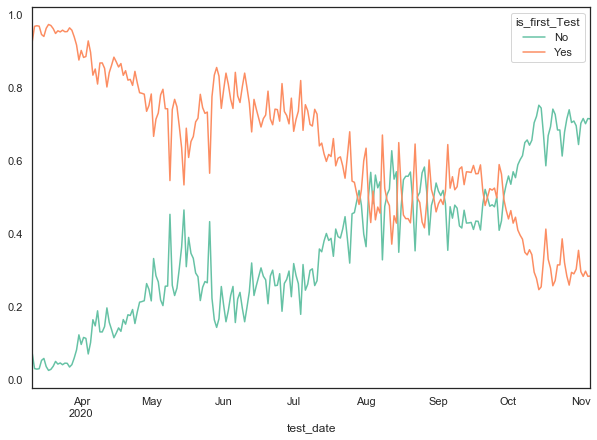

In [36]:
ti = bdi[(bdi.test_date>'2020') 
         & (bdi.test_date<'2021') 
         & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

In [37]:
(ti.div(ti.sum(axis=1), axis=0))

is_first_Test        No       Yes
test_date                        
2020-03-11     0.073446  0.926554
2020-03-12     0.030817  0.969183
2020-03-13     0.029178  0.970822
2020-03-14     0.030464  0.969536
2020-03-15     0.053219  0.946781
...                 ...       ...
2020-11-01     0.703507  0.296493
2020-11-02     0.716465  0.283535
2020-11-03     0.702145  0.297855
2020-11-04     0.716377  0.283623
2020-11-05     0.715474  0.284526

[240 rows x 2 columns]

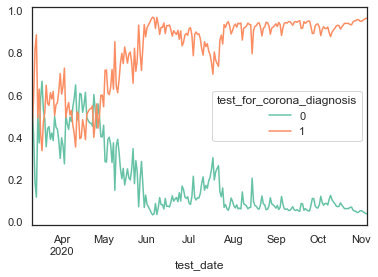

In [38]:
ti = bdi[(bdi.is_first_Test=='No')].groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

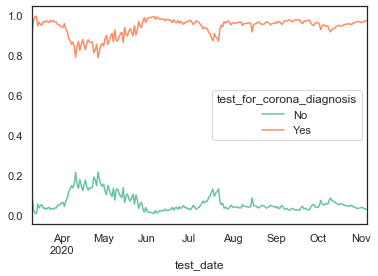

In [39]:
ti = bdi.groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
ti = ti.rename(columns={0: 'No', 1: 'Yes'})
(ti.div(ti.sum(axis=1), axis=0)).plot()

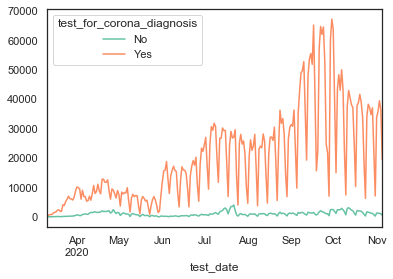

In [40]:
ti.plot()

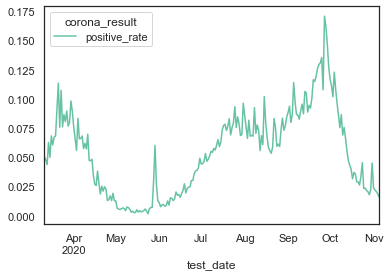

In [41]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain))[['positive_rate']]
 .plot())

In [42]:
import altair as alt

In [43]:
ti.tail()

test_for_corona_diagnosis    No    Yes
test_date                             
2020-11-01                 1291  33876
2020-11-02                 1271  35865
2020-11-03                 1214  39479
2020-11-04                 1049  36404
2020-11-05                  517  19471

In [44]:
ti.Yes.sum() + ti.No.sum()

5028236

In [45]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [46]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [47]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [48]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')
          ]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [49]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [50]:
get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')

'datagov_archive\\corona_hospitalization_ver_00130_20201108105451.xlsx.gz'

In [51]:
import gzip
hos = (pd.read_excel(gzip.open(get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')))
       .fillna('<15')
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.tail()

date  מאושפזים  אחוז נשים מאושפזות  גיל ממוצע מאושפזים  \
235 2020-11-01       724                41.4                  65   
236 2020-11-02       688                41.6                  65   
237 2020-11-03       664                43.1                  65   
238 2020-11-04       627                42.6                  65   
239 2020-11-05       623                43.8                  65   

     סטיית תקן גיל מאושפזים  resp  אחוז נשים מונשמות  גיל ממוצע מונשמים  \
235                    17.8   166               31.3                 66   
236                    17.3   166               33.7                 66   
237                    17.1   159               35.8                 65   
238                    17.1   148               34.5                 65   
239                    17.4   148               33.1                 66   

     סטיית תקן גיל מונשמים  חולים קל  ...  סטיית תקן גיל חולים קל  medium  \
235                   12.4       204  ...                    22.4     130   
236                   12.1       185  ...                    22.1     108   
237                   12.9       176  ...                    21.0     112   
238                   13.3       163  ...                    21.4     111   
239                   12.2       178  ...                    21.7     114   

     אחוז נשים חולות בינוני  גיל ממוצע חולים בינוני  \
235                    39.2                      68   
236                    41.7                      68   
237                    46.4                      66   
238                    41.4                      66   
239                      50                      66   

    סטיית תקן גיל חולים בינוני critical אחוז נשים חולות קשה  \
235                       17.7      390                39.5   
236                       17.2      395                39.7   
237                       17.3      376                38.8   
238                       16.7      353                39.9   
239                         18      331                38.4   

     גיל ממוצע חולים קשה  סטיית תקן גיל חולים קשה  חולים קשה מצטבר  
235                   67                     14.0             6956  
236                   67                     13.8             6988  
237                   67                     14.6             7017  
238                   67                     14.4             7035  
239                   67                     13.4             7048  

[5 rows x 22 columns]

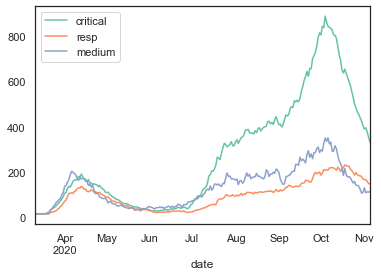

In [52]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [53]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


test_date  critical  resp  medium  borderline  in_progress  negative  \
0 2020-03-11        15    15      15         0.0         18.0     324.0   
1 2020-03-12        15    15      15         0.0          2.0     616.0   
2 2020-03-13        15    15      15         0.0          0.0     721.0   
3 2020-03-14        15    15      15         0.0          3.0     704.0   
4 2020-03-15        15    15      15         0.0         93.0    1025.0   

   not_done  positive  uncertain  positive_rate  
0       0.0      45.0        0.0       0.121951  
1       1.0      45.0        0.0       0.068079  
2       0.0      38.0        0.0       0.050066  
3       1.0      50.0        0.0       0.066313  
4       9.0     103.0        0.0       0.091312

In [54]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [55]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


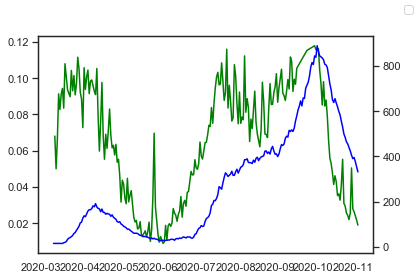

In [56]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [57]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [58]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [59]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

In [60]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'lab_id', 'corona_result']].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative+polab.borderline+polab.uncertain)

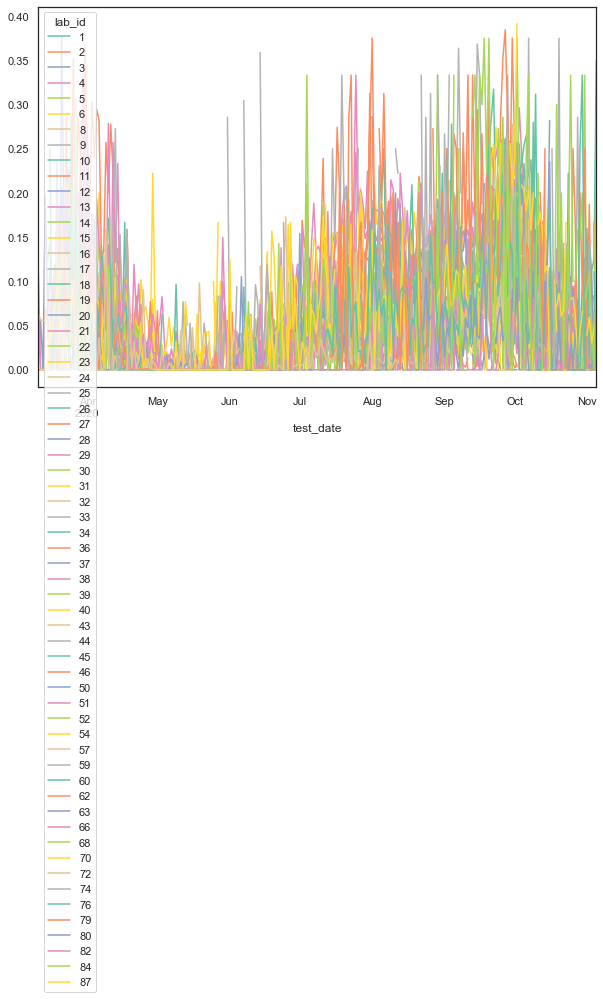

In [61]:
polab[polab.positive_rate<0.4].positive_rate.unstack().plot(figsize=(10,7))

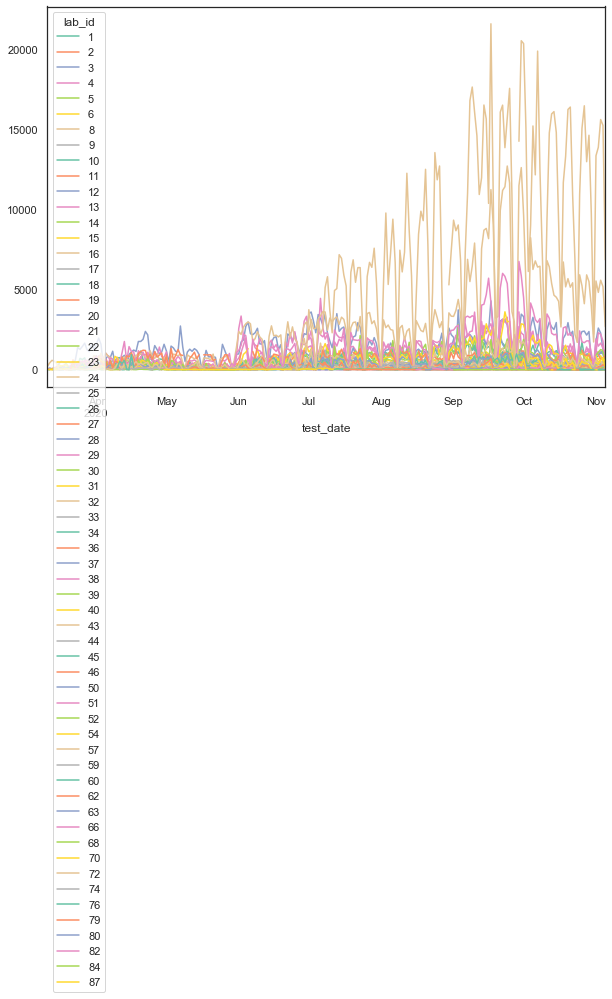

In [62]:
polab.total_tests.unstack().plot(figsize=(10,7))

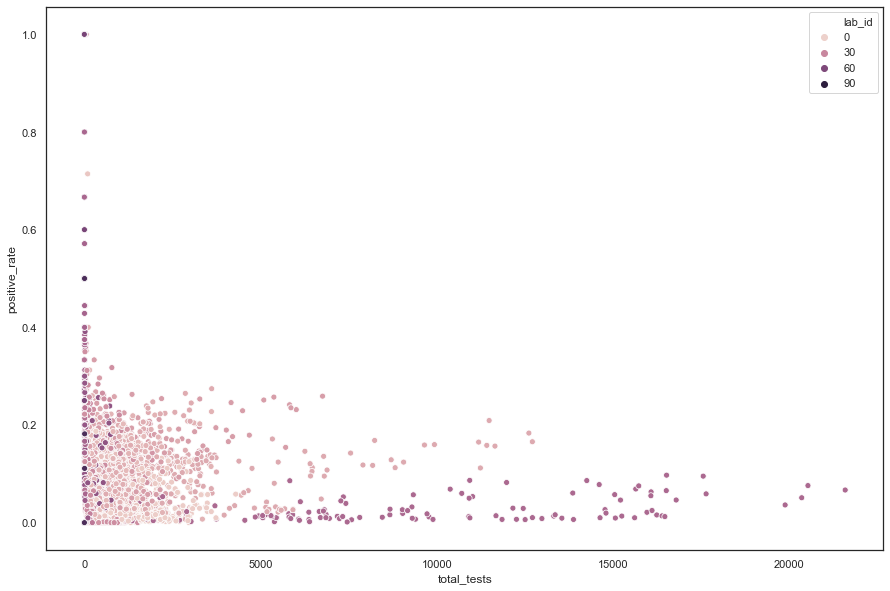

In [63]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [64]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [65]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [66]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result  positive   negative  total_tests  positive_rate
lab_id                                                        
43              36772.0  1074618.0    1126112.0            1.7
16              61207.0   577089.0     642684.0            5.3
3               10805.0   352412.0     365501.0            1.5
21              44963.0   271934.0     321786.0            8.3
13              26022.0   240357.0     273107.0            5.4
...                 ...        ...          ...            ...
74                  9.0        0.0         33.0            inf
59                  7.0        0.0         27.0            inf
87                  0.0        0.0         25.0            NaN
63                  0.0        0.0         21.0            NaN
72                  0.0        0.0         20.0            NaN

[62 rows x 4 columns]

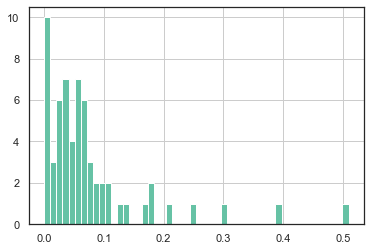

In [67]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [68]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:10]
top_5_labs

Int64Index([43, 16, 3, 21, 13, 4, 15, 10, 12, 14], dtype='int64')

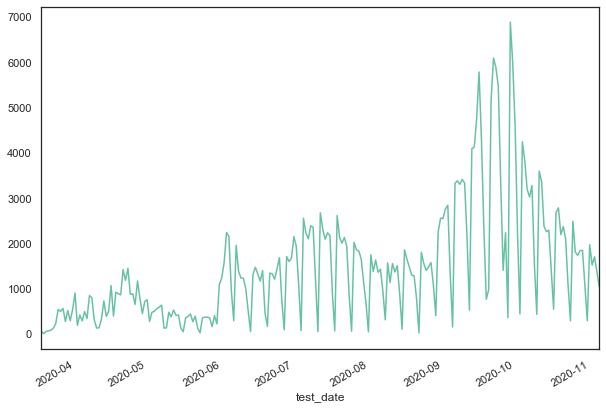

In [69]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

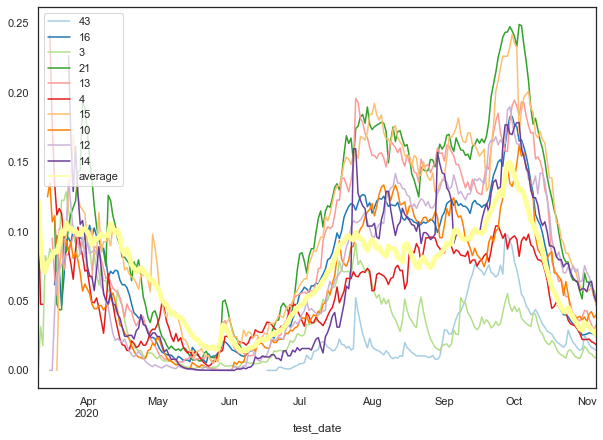

In [70]:
sns.set_palette(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


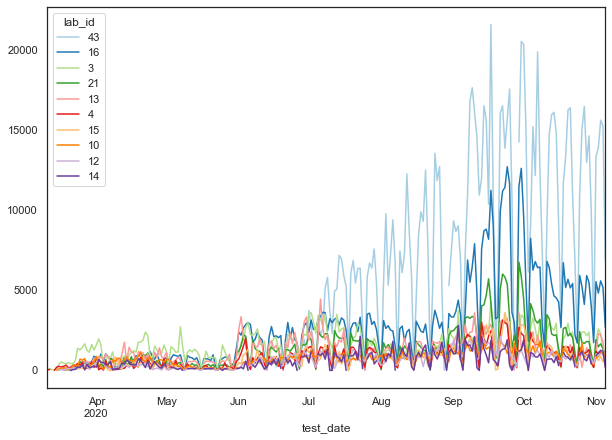

In [71]:
forp = polab.total_tests.unstack()[top_5_labs]
ax = forp.plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


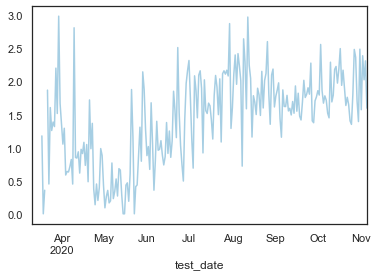

In [72]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [73]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06680821376210065

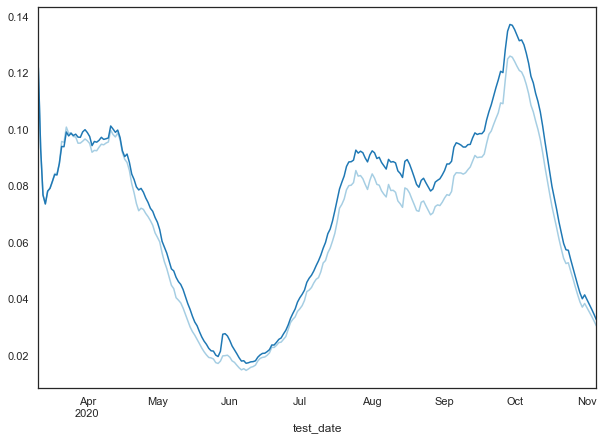

In [74]:
ax = (bdi[~(bdi.lab_id.isin([13,21]))].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

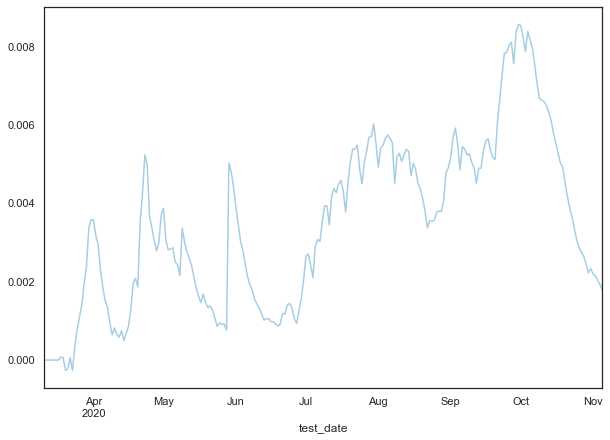

In [75]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

In [76]:
alt.Chart(polab[polab.total_tests>100].reset_index()).mark_point(size=2).encode(
    x='test_date',
    y='total_tests',
    color='positive_rate:Q',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [77]:
xx = (polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1))
 .assign(positive_rq = lambda x: pd.qcut(x.positive_rate, 5))
)
xx

corona_result  positive   negative  total_tests  positive_rate   positive_rq
lab_id                                                                      
43              36772.0  1074618.0    1126112.0            1.7  (0.499, 1.8]
16              61207.0   577089.0     642684.0            5.3  (4.56, 8.18]
3               10805.0   352412.0     365501.0            1.5  (0.499, 1.8]
21              44963.0   271934.0     321786.0            8.3   (8.18, inf]
13              26022.0   240357.0     273107.0            5.4  (4.56, 8.18]
...                 ...        ...          ...            ...           ...
74                  9.0        0.0         33.0            inf   (8.18, inf]
59                  7.0        0.0         27.0            inf   (8.18, inf]
87                  0.0        0.0         25.0            NaN           NaN
63                  0.0        0.0         21.0            NaN           NaN
72                  0.0        0.0         20.0            NaN           NaN

[62 rows x 5 columns]

In [78]:
polab = polab.reset_index()
polab['total_pr'] = polab.lab_id.map(xx.positive_rate)
polab['total_prq'] = polab.lab_id.map(xx.positive_rq)
polab = polab.set_index(['test_date', 'lab_id'])
polab.head()

corona_result      Other  borderline  in_progress  negative  not_done  \
test_date  lab_id                                                       
2020-03-11 1         0.0         0.0          0.0       0.0       0.0   
           2         0.0         0.0          0.0      70.0       0.0   
           3         1.0         0.0          1.0      36.0       0.0   
           4         0.0         0.0          0.0      16.0       0.0   
           6         0.0         0.0         16.0       0.0       0.0   

corona_result      positive  uncertain  total_tests  positive_rate  total_pr  \
test_date  lab_id                                                              
2020-03-11 1            2.0        0.0          2.0       1.000000      27.2   
           2            0.0        0.0         70.0       0.000000       1.8   
           3            0.0        0.0         38.0       0.000000       1.5   
           4            2.0        0.0         18.0       0.111111       3.5   
           6            0.0        0.0         16.0            NaN       1.3   

corona_result         total_prq  
test_date  lab_id                
2020-03-11 1        (8.18, inf]  
           2       (0.499, 1.8]  
           3       (0.499, 1.8]  
           4        (2.9, 4.56]  
           6       (0.499, 1.8]

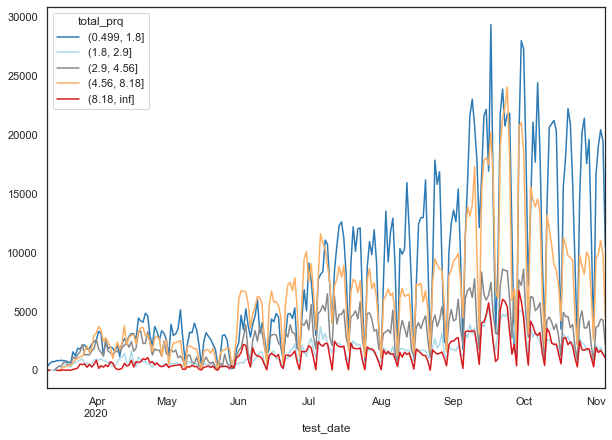

In [79]:
sns.set_palette(['#d7191c','#fdae61','#888888','#abd9e9','#2c7bb6'][::-1])
#sns.set_palette(['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])
sns.set_style('white')
prq = (polab.reset_index()
 .groupby(['test_date', 'total_prq']).total_tests.sum()
 .unstack()
)
prq.plot(figsize=(10,7))

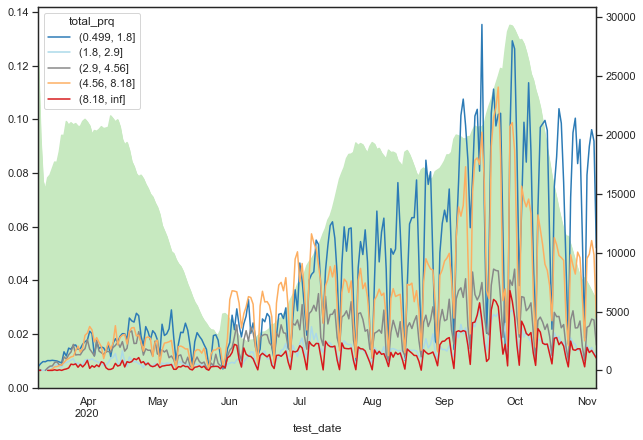

In [80]:
ax=(bdi.groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
    .assign(pr = lambda x: x.positive/(x.negative+x.positive+x.borderline+x.uncertain))
   ).pr.ewm(7).mean().plot(color='#c7e9c0', kind='area', figsize=(10,7))
ax2=ax.twinx()
prq.plot(ax=ax2)

## Decseased 

In [81]:
last_dec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_deceased_ver*.csv.gz'), 
                       encoding='1255', low_memory=False, compression='gzip')
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 2.0]    0.188787
(2.0, 5.0]       0.120137
(5.0, 6.0]       0.055683
(6.0, 9.0]       0.125095
(9.0, 11.0]      0.079329
(11.0, 14.0]     0.088863
(14.0, 17.0]     0.072845
(17.0, 22.0]     0.095347
(22.0, 30.0]     0.081617
(30.0, 209.0]    0.086575
Name: qc, dtype: float64

In [82]:
sns.set_palette('Set2')


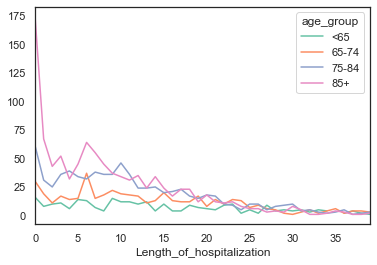

In [83]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

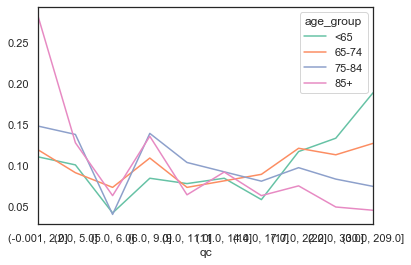

In [84]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [85]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.107170
1.0    0.047674
2.0    0.033944
3.0    0.044241
4.0    0.034706
5.0    0.041190
6.0    0.055683
7.0    0.043860
8.0    0.039283
9.0    0.041953
Name: Length_of_hospitalization, dtype: float64

In [86]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-203.0    0.000381
-141.0    0.000381
-63.0     0.000381
-52.0     0.000381
-44.0     0.000381
-36.0     0.000381
-35.0     0.000763
-31.0     0.000381
-28.0     0.000381
-26.0     0.000763
Name: Time_between_positive_and_hospitalization, dtype: float64

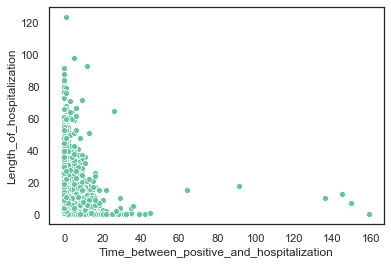

In [87]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

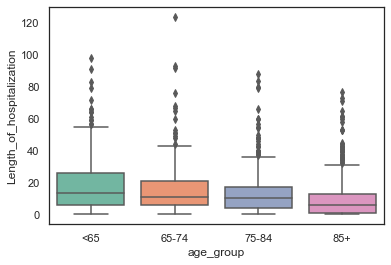

In [88]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [89]:
decs = []
for file in sorted(glob.glob('datagov_archive/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    for enc in ['1255', 'utf-8-sig']:
        try:
            dec = pd.read_csv(file, 
                  encoding=enc, low_memory=False)
        except:
            continue
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

gender age_group  Ventilated  Time_between_positive_and_hospitalization  \
0      זכר       <65         1.0                                        2.0   
203   נקבה     75-84         1.0                                        0.0   
202   נקבה       85+         0.0                                       10.0   
201   נקבה       85+         0.0                                        2.0   
200    זכר       85+         1.0                                        0.0   

     Length_of_hospitalization  Time_between_positive_and_death  \
0                         20.0                             22.0   
203                       12.0                             12.0   
202                        1.0                             11.0   
201                       17.0                             19.0   
200                        9.0                              9.0   

                   time                                            file  
0   2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
203 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
202 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
201 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
200 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz

In [90]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((44426, 8), (2109, 8))

In [91]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

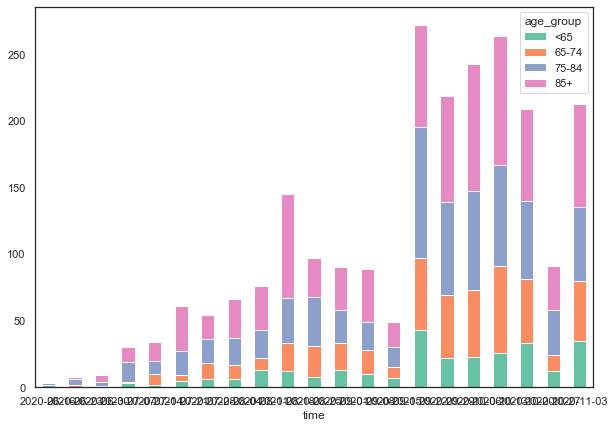

In [92]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

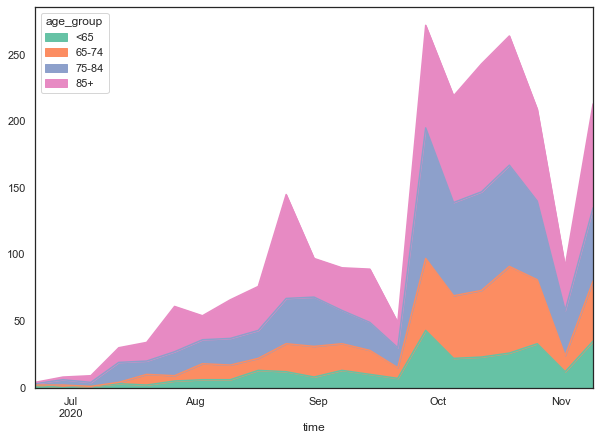

In [93]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

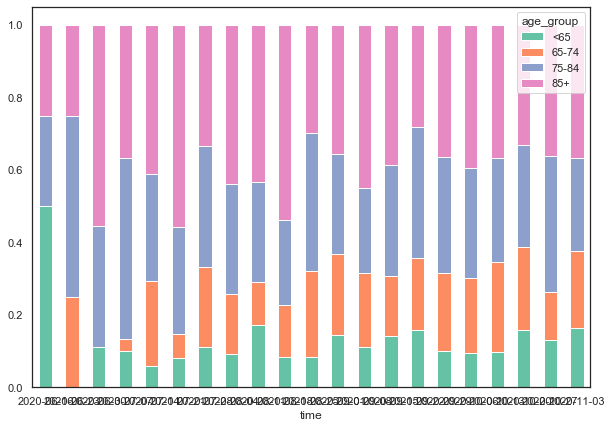

In [94]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [95]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


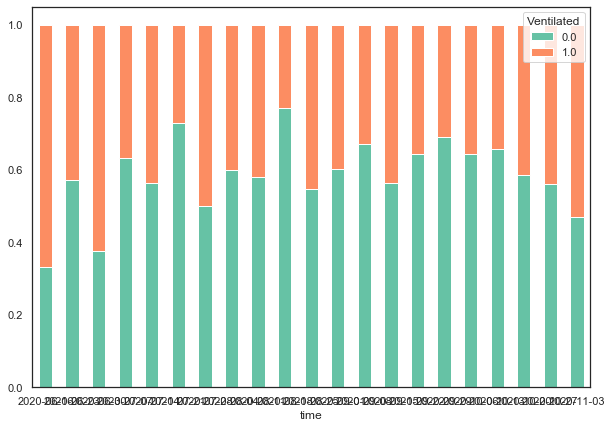

In [96]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

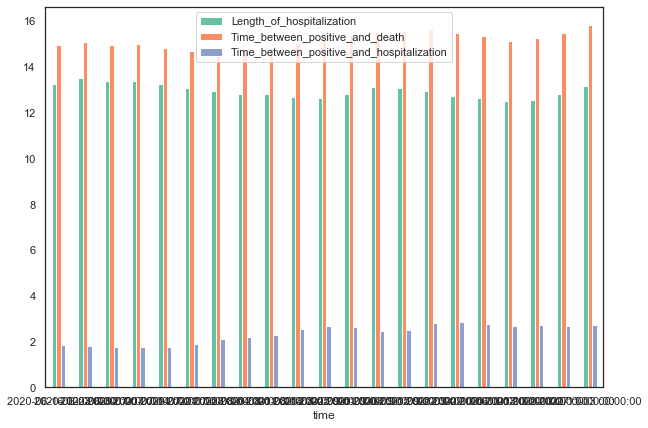

In [97]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


In [98]:
hos.head().T

0                    1  \
date                        2020-03-11 00:00:00  2020-03-12 00:00:00   
מאושפזים                                     79                  102   
אחוז נשים מאושפזות                         36.7                 40.2   
גיל ממוצע מאושפזים                           48                   50   
סטיית תקן גיל מאושפזים                     17.9                 18.1   
resp                                         15                   15   
אחוז נשים מונשמות                            20                   20   
גיל ממוצע מונשמים                            64                   64   
סטיית תקן גיל מונשמים                      15.4                 15.4   
חולים קל                                     72                   95   
אחוז נשים חולות קל                         37.5                 41.1   
גיל ממוצע חולים קל                           47                   49   
סטיית תקן גיל חולים קל                     17.3                 17.8   
medium                                       15                   15   
אחוז נשים חולות בינוני                      <15                  <15   
גיל ממוצע חולים בינוני                      <15                  <15   
סטיית תקן גיל חולים בינוני                  <15                  <15   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                 33.3   
גיל ממוצע חולים קשה                          67                   67   
סטיית תקן גיל חולים קשה                    16.3                 16.3   
חולים קשה מצטבר                             <15                  <15   

                                              2                    3  \
date                        2020-03-13 00:00:00  2020-03-14 00:00:00   
מאושפזים                                    120                  158   
אחוז נשים מאושפזות                         39.2                 41.1   
גיל ממוצע מאושפזים                           50                   48   
סטיית תקן גיל מאושפזים                     18.2                 18.4   
resp                                         15                   15   
אחוז נשים מונשמות                            20                    0   
גיל ממוצע מונשמים                            64                   70   
סטיית תקן גיל מונשמים                      15.4                  7.4   
חולים קל                                    109                  148   
אחוז נשים חולות קל                         39.4                 41.9   
גיל ממוצע חולים קל                           48                   46   
סטיית תקן גיל חולים קל                     17.5                 17.5   
medium                                       15                   15   
אחוז נשים חולות בינוני                       40                   40   
גיל ממוצע חולים בינוני                       68                   68   
סטיית תקן גיל חולים בינוני                   17                   17   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                   20   
גיל ממוצע חולים קשה                          67                   76   
סטיית תקן גיל חולים קשה                    16.3                 10.3   
חולים קשה מצטבר                             <15                  <15   

                                              4  
date                        2020-03-15 00:00:00  
מאושפזים                                    197  
אחוז נשים מאושפזות                         44.2  
גיל ממוצע מאושפזים                           47  
סטיית תקן גיל מאושפזים                     18.7  
resp                                         15  
אחוז נשים מונשמות                            20  
גיל ממוצע מונשמים                            74  
סטיית תקן גיל מונשמים                       7.6  
חולים קל                                    182  
אחוז נשים חולות קל                         44.5  
גיל ממוצע חולים קל                           45  
סטיית תקן גיל חולים קל                     17.6  
medium                          

In [99]:
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

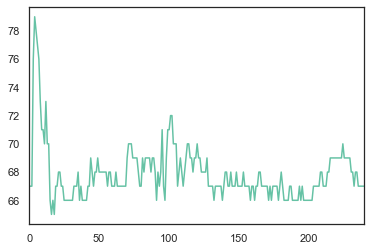

In [100]:
hos['גיל ממוצע חולים קשה'].plot()

## Recovered

In [101]:
pd.read_csv('datagov_archive/corona_recovered_ver_004.csv.gz', encoding='1255')

days_between_pos_and_neg total_tests_count age_group gender  \
0                          8.0                 9     40-49   נקבה   
1                         19.0                 9     30-39    זכר   
2                         33.0                 9       60+    זכר   
3                         24.0                 9     30-39    זכר   
4                         20.0                 9     40-49    זכר   
...                        ...               ...       ...    ...   
6408                       NaN               NaN       60+    זכר   
6409                       NaN               NaN       60+   נקבה   
6410                       NaN               NaN       60+   נקבה   
6411                       NaN               NaN       60+    זכר   
6412                       NaN               NaN       60+    זכר   

             test_indication  
0     Contact with confirmed  
1     Contact with confirmed  
2                     Abroad  
3     Contact with confirmed  
4                     Abroad  
...                      ...  
6408                   Other  
6409  Contact with confirmed  
6410  Contact with confirmed  
6411                  Abroad  
6412                  Abroad  

[6413 rows x 5 columns]

In [102]:
recs = []
for file in sorted(glob.glob('datagov_archive/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

datagov_archive\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
datagov_archive\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
datagov_archive\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
datagov_archive\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
datagov_archive\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
datagov_archive\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
datagov_archive\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
datagov_archive\corona_recovered_ver_00

days_between_pos_and_neg total_tests_count age_group gender  \
4923                      12.0                 3     30-39   נקבה   
4281                      15.0                 3     40-49   נקבה   
4280                       4.0                 3     20-29   נקבה   
4279                      13.0                 3     50-59    זכר   
4278                       7.0                 3     30-39   נקבה   

     test_indication                time  \
4923           Other 2020-05-30 14:05:58   
4281           Other 2020-05-30 14:05:58   
4280           Other 2020-05-30 14:05:58   
4279           Other 2020-05-30 14:05:58   
4278          Abroad 2020-05-30 14:05:58   

                                                 file  ver  
4923  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4281  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4280  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4279  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4278  datagov_archive\corona_recovered_ver_004.csv.gz    4

In [103]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

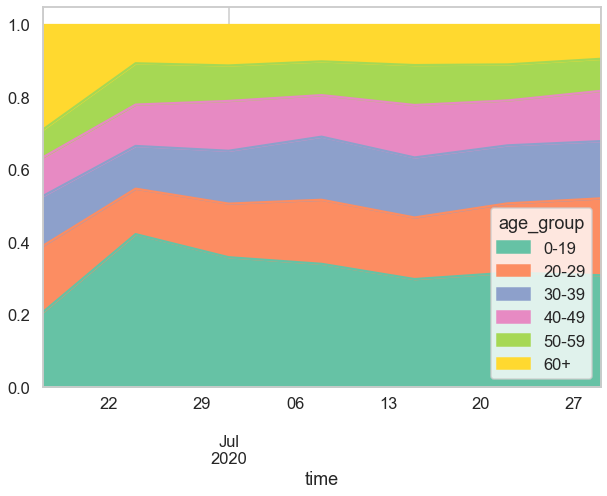

In [104]:
sns.set_style('whitegrid')
sns.set_context('talk')

rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [105]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='datagov_archive', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

first_week_day last_week_day age_group   gender weekly_tests_num  \
0     2020-03-15    2020-03-21      0-19     נקבה            902.0   
1     2020-03-15    2020-03-21      0-19  לא ידוע             29.0   
2     2020-03-15    2020-03-21      0-19      זכר           1085.0   
3     2020-03-15    2020-03-21     20-24  לא ידוע              <15   
4     2020-03-15    2020-03-21     20-24     נקבה            623.0   

  weekly_newly_tested weekly_cases weekly_deceased  
0               865.0         39.0             0.0  
1                29.0          0.0             0.0  
2              1034.0         37.0             0.0  
3                 <15          0.0             0.0  
4               604.0         34.0             0.0

In [106]:
ag.weekly_deceased.value_counts()

0.0     1124
<15      314
27.0       4
21.0       3
17.0       3
15.0       3
20.0       3
22.0       2
25.0       2
34.0       2
18.0       2
26.0       2
51.0       2
16.0       2
28.0       1
33.0       1
32.0       1
54.0       1
61.0       1
74.0       1
41.0       1
66.0       1
44.0       1
35.0       1
23.0       1
76.0       1
47.0       1
31.0       1
58.0       1
24.0       1
70.0       1
Name: weekly_deceased, dtype: int64

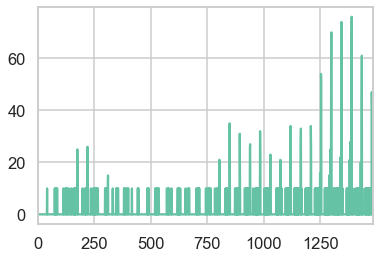

In [107]:
ag.weekly_deceased.replace('<15','10').astype(float).astype(int).plot()

## Dashboard Data

In [108]:
dash_folder = 'dashboard_data'
city_file_name = 'contagionDataPerCityPublic.csv'

In [109]:
city_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                city_df = city_df.append(pd.read_csv(os.path.join(tfolder, city_file_name)), sort=False)
                
city_df['date'] = pd.to_datetime(city_df.date)
city_df.head()

city sickCount actualSick verifiedLast7Days  testLast7Days  \
0        ירושלים     16214       3748              1266          13868   
1        בני ברק      9144       1252               482           3043   
2  מודיעין עילית      3122       1085               475           2004   
3            רהט       780        240               118            792   
4       כפר קאסם       455        185               109            501   

   patientDiffPopulationForTenThousands                             status  \
0                                    40  נדרשים הסברה, בדיקות ואכיפת בידוד   
1                                    62  נדרשים הסברה, בדיקות ואכיפת בידוד   
2                                   141  נדרשים הסברה, בדיקות ואכיפת בידוד   
3                                    36  נדרשים הסברה, בדיקות ואכיפת בידוד   
4                                    77  נדרשים הסברה, בדיקות ואכיפת בידוד   

                 lastUpdate                             date  
0  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
1  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
2  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
3  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
4  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00

In [110]:
city_df.dtypes

city                                                 object
sickCount                                            object
actualSick                                           object
verifiedLast7Days                                    object
testLast7Days                                         int64
patientDiffPopulationForTenThousands                  int64
status                                               object
lastUpdate                                           object
date                                    datetime64[ns, UTC]
dtype: object

In [111]:
city_tests = (city_df
              .groupby([pd.Grouper(key='date', freq='1d'), 'city'])['testLast7Days', 'verifiedLast7Days'].max()
              .assign(positive_rate = lambda x: x.verifiedLast7Days.str.strip().replace('<15', '8').replace('1-5', '3').replace('6-10', '8').replace('11-14', '13').astype(int) / x.testLast7Days)
              .reset_index())
city_tests.head()

date                city  testLast7Days  \
0 2020-08-19 00:00:00+00:00  אבו ג'ווייעד (שבט)             12   
1 2020-08-19 00:00:00+00:00             אבו גוש            256   
2 2020-08-19 00:00:00+00:00            אבו סנאן            399   
3 2020-08-19 00:00:00+00:00   אבו קורינאת (שבט)             13   
4 2020-08-19 00:00:00+00:00   אבו רובייעה (שבט)             20   

  verifiedLast7Days  positive_rate  
0                 0       0.000000  
1                24       0.093750  
2                18       0.045113  
3                 0       0.000000  
4                 0       0.000000

In [112]:
#top_cities = city_tests.groupby('city').testLast7Days.mean().sort_values(ascending=False)[:20].index
from datetime import date, timedelta
yesterday = city_tests.date.max() - timedelta(days=1)
top_cities = city_tests[city_tests.date==yesterday].sort_values(by='testLast7Days', ascending=False).head(20).city

In [113]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='testLast7Days',
    size=alt.Size('positive_rate:Q', bin={'steps':[0.02,0.05,0.1]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [114]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).transform_joinaggregate(
     groupby = ['date'], TotalTests='sum(testLast7Days)',
).transform_calculate(
    PercentTests="datum.testLast7Days / datum.TotalTests"
).mark_area().encode(
    x='date',
    y='PercentTests:Q',
    color='city',
    #size='mean(positive_rate)',
    tooltip=['date', 'city', 'PercentTests:Q']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [115]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='positive_rate',
    size=alt.Size('testLast7Days', bin={'steps':[1000,2000,5000,10000]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [116]:
ct_change = (city_tests[city_tests.date.isin(['2020-08-31',yesterday.strftime('%Y-%m-%d') ])]
 .assign(date = lambda x: x.date.dt.strftime('%Y-%m-%d'))            
 .pivot(index='city', columns='date')[['testLast7Days', 'positive_rate']]
 .assign(test_ratio=lambda x: (x.iloc[:, 1]/x.iloc[:,0]).round(2))
 .assign(pr_ratio=lambda x: (x.iloc[:, 3]/x.iloc[:,2]).round(2))
 .assign(positive_rate = lambda x: x.positive_rate.round(2))
 .sort_values(by='test_ratio', ascending=False)
 
 )
ct_change[ct_change[('testLast7Days', yesterday.strftime('%Y-%m-%d'))]>=300].head(30)#.loc[list(top_cities), :]


testLast7Days            positive_rate            test_ratio  \
date                2020-08-31 2020-11-07    2020-08-31 2020-11-07              
city                                                                            
מסעדה                       18        336          0.17       0.10      18.67   
מג'דל שמס                  103       1642          0.08       0.07      15.94   
חצור הגלילית                75        898          0.11       0.06      11.97   
אילת                       520       2841          0.05       0.00       5.46   
בית אל                      95        360          0.03       0.01       3.79   
ערד                        346       1162          0.02       0.02       3.36   
כפר חב"ד                   102        307          0.13       0.03       3.01   
מזכרת בתיה                 180        485          0.04       0.01       2.69   
בועיינה-נוג'ידאת           151        399          0.14       0.06       2.64   
אריאל                      206        538          0.01       0.01       2.61   
חורפיש                     131        341          0.02       0.08       2.60   
זכרון יעקב                 244        575          0.06       0.01       2.36   
ראש העין                   981       2182          0.06       0.01       2.22   
מעלות-תרשיחא               367        748          0.04       0.02       2.04   
גבעתיים                    714       1437          0.04       0.01       2.01   
אור עקיבא                  285        564          0.06       0.03       1.98   
קרית אונו                  476        920          0.06       0.00       1.93   
דייר חנא                   266        505          0.08       0.10       1.90   
אפרת                       174        328          0.07       0.02       1.89   
נס ציונה                   488        893          0.05       0.00       1.83   
יפיע                       227        416          0.11       0.09       1.83   
כפר יונה                   300        541          0.01       0.01       1.80   
באר שבע                   4181       7482          0.03       0.02       1.79   
שדרות                      362        642          0.04       0.00       1.77   
פרדס חנה-כרכור             642       1115          0.05       0.01       1.74   
פתח תקווה                 3878       6651          0.05       0.02       1.72   
נצרת                       956       1637          0.10       0.08       1.71   
יבנה                       521        888          0.08       0.01       1.70   
בוקעאתא                    206        351          0.23       0.24       1.70   
גבעת שמואל                 302        513          0.07       0.00       1.70   

                 pr_ratio  
date                       
city                       
מסעדה                0.57  
מג'דל שמס            0.85  
חצור הגלילית         0.52  
אילת                 0.05  
בית אל               0.26  
ערד                  0.67  
כפר חב"ד             0.20  
מזכרת בתיה           0.14  
בועיינה-נוג'ידאת     0.43  
אריאל                1.02  
חורפיש               3.33  
זכרון יעקב           0.23  
ראש העין             0.24  
מעלות-תרשיחא         0.64  
גבעתיים              0.40  
אור עקיבא            0.51  
קרית אונו            0.06  
דייר חנא             1.27  
אפרת                 0.33  
נס ציונה             0.07  
יפיע                 0.78  
כפר יונה             0.55  
באר שבע              0.46  
שדרות                0.11  
פרדס חנה-כרכור       0.24  
פתח תקווה            0.31  
נצרת                 0.74  
יבנה                 0.18  
בוקעאתא              1.01  
גבעת שמואל           0.00

C:\Users\dbare\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


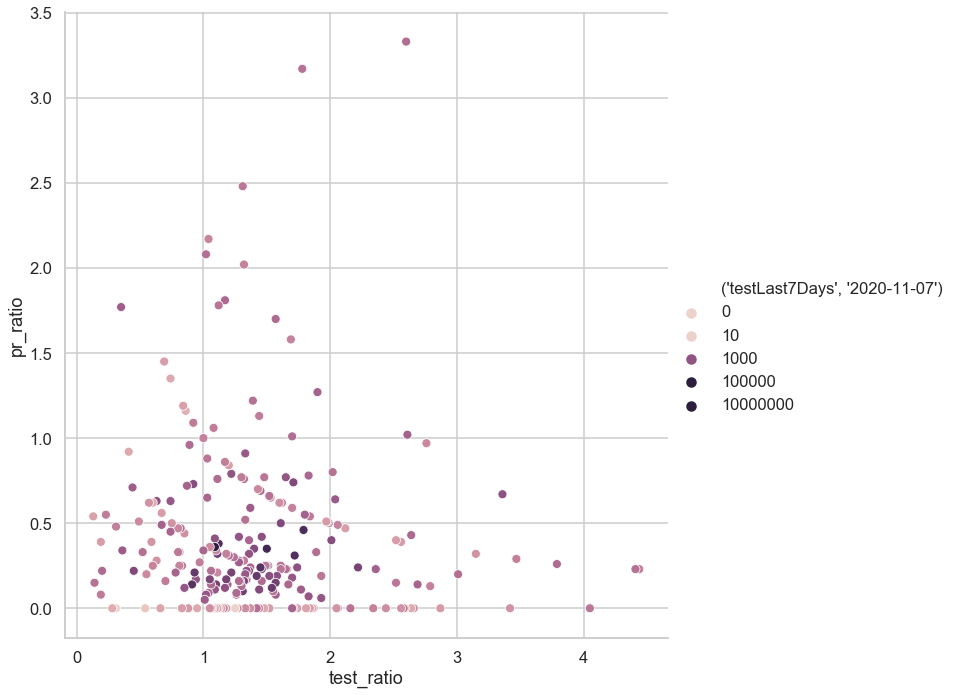

In [117]:
from matplotlib.colors import LogNorm

sns.relplot(data=ct_change[(ct_change.test_ratio<5) & (ct_change.pr_ratio<4)], x='test_ratio', y='pr_ratio', 
            hue=('testLast7Days', yesterday.strftime('%Y-%m-%d')), hue_norm=LogNorm(),
            height=10)

In [118]:
tr_file_name = 'testResultsPerDate.csv'

In [119]:
tr_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                tr_df = tr_df.append(pd.read_csv(os.path.join(tfolder, tr_file_name)), sort=False)
                
tr_df['date'] = pd.to_datetime(tr_df.date)
tr_df.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
280 2020-11-04 00:00:00+00:00   39783                 38683             764   
281 2020-11-05 00:00:00+00:00   35161                 34265             564   
282 2020-11-06 00:00:00+00:00   31533                 30674             702   
283 2020-11-07 00:00:00+00:00    8310                  8045             207   
284 2020-11-08 00:00:00+00:00     696                   669              24   

                   lastUpdate  
280  2020-11-08T03:40:08.473Z  
281  2020-11-08T03:40:08.473Z  
282  2020-11-08T03:40:08.473Z  
283  2020-11-08T03:40:08.473Z  
284  2020-11-08T03:40:08.473Z

In [120]:
tr_df.dtypes

date                    datetime64[ns, UTC]
amount                                int64
amountVirusDiagnosis                  int64
positiveAmount                        int64
lastUpdate                           object
dtype: object

In [121]:
tr = (tr_df.sort_values('lastUpdate', ascending=False)
              .groupby(['date']).head(1)
              .sort_values('date')
     .assign(positive_rate = lambda x: x.positiveAmount/x.amountVirusDiagnosis))
tr.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
280 2020-11-04 00:00:00+00:00   39783                 38683             764   
281 2020-11-05 00:00:00+00:00   35161                 34265             564   
282 2020-11-06 00:00:00+00:00   31533                 30674             702   
283 2020-11-07 00:00:00+00:00    8310                  8045             207   
284 2020-11-08 00:00:00+00:00     696                   669              24   

                   lastUpdate  positive_rate  
280  2020-11-08T03:40:08.473Z       0.019750  
281  2020-11-08T03:40:08.473Z       0.016460  
282  2020-11-08T03:40:08.473Z       0.022886  
283  2020-11-08T03:40:08.473Z       0.025730  
284  2020-11-08T03:40:08.473Z       0.035874